## Question 4: Predicting a book's reach

### 2. Modelling

#### Modeling Steps

**1. Training Baseline Models**
*   **Logic:** Traib three different linear models: **OLS** (Standard), **Ridge** (L2), and **Lasso** (L1) using their default settings.
*   **Reason:** This establishes a "baseline" performance. We need to know how well a simple model performs before we try to improve it.

**2. Fine-Tuning Hyperparameters**
*   **Logic:** For Ridge and Lasso, we tested a range of different "Alpha" values (Regularization Strength) on the **Validation Set**.
*   **Reason:** Choosing the right Alpha helps the model balance between being too simple (Underfitting) and too complex (Overfitting).

**3. Model Comparison & Selection**
*   **Logic:** We compared the RMSE (Error) and R² (Accuracy) scores of all models.
*   **Reason:** Choose the best model to perform final evaluation.

**4. Final Evaluation**
*   **Logic:** We ran the winning model on the **Test Set** and analyzed the **Feature Weights** (Coefficients).
*   **Reason:** This gives us an honest measure of how well the model works in the real world and tells us *which* features drive popularity.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

#### 2.1 Load Datasets

In [15]:
data_path = '../../Data/Processed'

X_train = pd.read_csv(f'{data_path}/X_train.csv')
y_train = pd.read_csv(f'{data_path}/y_train.csv').values.ravel()

X_val   = pd.read_csv(f'{data_path}/X_val.csv')
y_val   = pd.read_csv(f'{data_path}/y_val.csv').values.ravel()

X_test  = pd.read_csv(f'{data_path}/X_test.csv')
y_test  = pd.read_csv(f'{data_path}/y_test.csv').values.ravel()

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (3698, 32)
Val shape:   (792, 32)
Test shape:  (793, 32)


#### 2.2 Helper Functions

In [16]:
def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    
    return {'RMSE': rmse, 'R2': r2, 'MAE': mae}

def print_metrics(metrics, title):
    print(f"--- {title} ---")
    print(f"RMSE (Log): {metrics['RMSE']:.4f}")
    print(f"R2 Score:   {metrics['R2']:.4f}")
    print(f"MAE (Real): {metrics['MAE']:,.0f} ratings")
    print("-" * 30)

def fine_tune(model_class, X_train, y_train, X_val, y_val, param_name='alpha'):
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    
    best_alpha = None
    best_rmse = float('inf')
    best_model = None
    
    # find best hyperparameter for Ridge and Lasso
    print(f"Tuning {model_class.__name__}...")
    for alpha in alphas:
        model = model_class(**{param_name: alpha}) 
        model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
            best_model = model
            
    print(f"   > Best Alpha: {best_alpha} | Best Val RMSE: {best_rmse:.4f}")
    return best_model, best_alpha

final_results = []

#### 2.3 Train and Fine Tune Models

## Model 1: OLS

In [17]:
print("1. OLS")
ols = LinearRegression()

ols.fit(X_train, y_train)
ols_preds = ols.predict(X_val)

ols_metrics = get_metrics(y_val, ols_preds)
print_metrics(ols_metrics, "OLS Performance")

final_results.append({'Model': 'OLS', 'State': 'Baseline', **ols_metrics})

1. OLS
--- OLS Performance ---
RMSE (Log): 1.0775
R2 Score:   0.6262
MAE (Real): 79,968 ratings
------------------------------


## Model 2: Ridge Regression

In [18]:
print("Ridge Regression")

# Train model
ridge_base = Ridge(alpha=1.0)
ridge_base.fit(X_train, y_train)

r_base_metrics = get_metrics(y_val, ridge_base.predict(X_val))
print_metrics(r_base_metrics, "Ridge Baseline (Alpha=1.0)")

final_results.append({'Model': 'Ridge', 'State': 'Baseline', **r_base_metrics})

# Fine tune model
best_ridge, ridge_alpha = fine_tune(Ridge, X_train, y_train, X_val, y_val)

r_tuned_metrics = get_metrics(y_val, best_ridge.predict(X_val))
print_metrics(r_tuned_metrics, f"Ridge Tuned (Alpha={ridge_alpha})")

final_results.append({'Model': 'Ridge', 'State': 'Tuned', **r_tuned_metrics})

Ridge Regression
--- Ridge Baseline (Alpha=1.0) ---
RMSE (Log): 1.0772
R2 Score:   0.6264
MAE (Real): 79,928 ratings
------------------------------
Tuning Ridge...
   > Best Alpha: 10 | Best Val RMSE: 1.0764
--- Ridge Tuned (Alpha=10) ---
RMSE (Log): 1.0764
R2 Score:   0.6270
MAE (Real): 79,692 ratings
------------------------------


## Model 3: Lasso Regression

In [19]:
print("3. Lasso Regression")

# Train model
lasso_base = Lasso(alpha=0.1) 
lasso_base.fit(X_train, y_train)

l_base_metrics = get_metrics(y_val, lasso_base.predict(X_val))
print_metrics(l_base_metrics, "Lasso Baseline (Alpha=0.1)")

final_results.append({'Model': 'Lasso', 'State': 'Baseline', **l_base_metrics})

# Fine tune model
best_lasso, lasso_alpha = fine_tune(Lasso, X_train, y_train, X_val, y_val)

l_tuned_metrics = get_metrics(y_val, best_lasso.predict(X_val))
print_metrics(l_tuned_metrics, f"Lasso Tuned (Alpha={lasso_alpha})")

final_results.append({'Model': 'Lasso', 'State': 'Tuned', **l_tuned_metrics})

3. Lasso Regression
--- Lasso Baseline (Alpha=0.1) ---
RMSE (Log): 1.1591
R2 Score:   0.5674
MAE (Real): 82,604 ratings
------------------------------
Tuning Lasso...
   > Best Alpha: 0.001 | Best Val RMSE: 1.0775
--- Lasso Tuned (Alpha=0.001) ---
RMSE (Log): 1.0775
R2 Score:   0.6262
MAE (Real): 79,936 ratings
------------------------------


#### 2.4 Model Comparison

In [20]:

print("Model Comparison")
results_df = pd.DataFrame(final_results)

results_df = results_df.sort_values(by='RMSE', ascending=True)
print(results_df)

best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model: {best_model_name} (Tuned)")

if best_model_name == 'OLS':
    final_model = ols
elif best_model_name == 'Ridge':
    final_model = best_ridge
else:
    final_model = best_lasso

Model Comparison
   Model     State      RMSE        R2           MAE
2  Ridge     Tuned  1.076361  0.626972  79692.306463
1  Ridge  Baseline  1.077185  0.626400  79928.301315
0    OLS  Baseline  1.077507  0.626177  79967.689252
4  Lasso     Tuned  1.077529  0.626162  79935.618630
3  Lasso  Baseline  1.159146  0.567384  82603.863517

Best model: Ridge (Tuned)


#### Observation:

**1. Fine-tuning**
*   The fine tuned versions of the models performed better than the baseline versions.
*   **Lasso** improved the most. Its baseline was poor ($R^2 = 0.56$), but tuning brought it up to match the others ($R^2 = 0.62$).

**2. Ridge is the Best Model**
*   **Ridge Regression (Tuned)** achieved the lowest error (RMSE) and the highest score ($R^2$), making it the best model for this dataset.

**3. Model Stability**
*   The difference between OLS, Ridge, and Lasso (Lasso after fine tunning) is very small. Preprocessing helps simpler models to perform on par with more complex models.

#### 2.4 Model Evaluation

In [21]:
print(f"\nFinal Evaluation on Test Set ({best_model_name})")
test_preds = final_model.predict(X_test)
test_metrics = get_metrics(y_test, test_preds)

print(f"RMSE (Log): {test_metrics['RMSE']:.4f}")
print(f"R2 Score:   {test_metrics['R2']:.4f}")
print(f"MAE (Real): {test_metrics['MAE']:,.0f}")


Final Evaluation on Test Set (Ridge)
RMSE (Log): 1.0703
R2 Score:   0.6381
MAE (Real): 77,022


**Final Score ($R^2 \approx 0.64$)**
*   Model understands **64%** of the reasons why a book becomes popular based purely on information available *before* release (like Author Reputation and Genre).

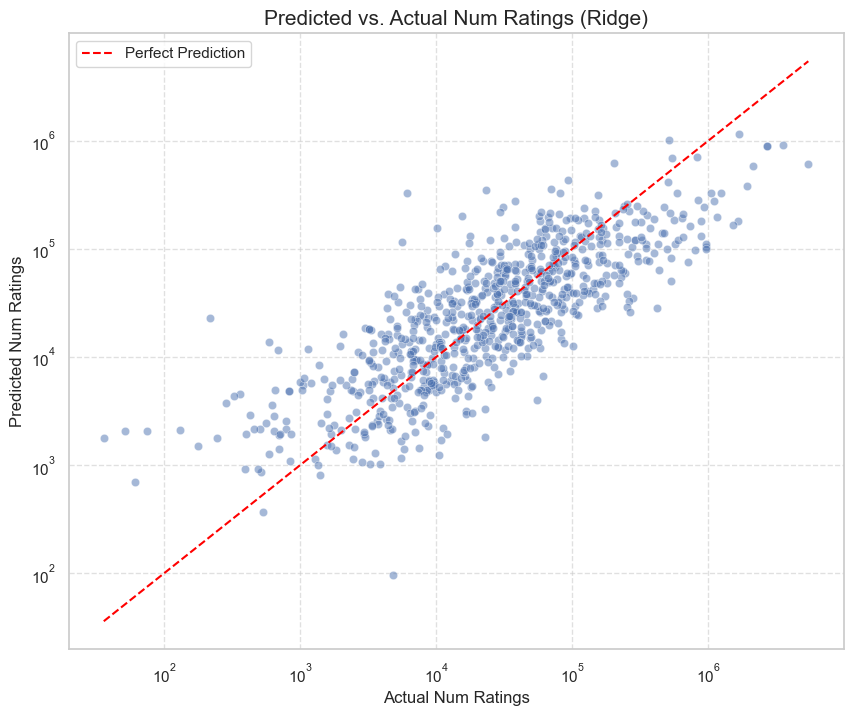

In [22]:
y_test_orig = np.expm1(y_test)
test_preds_orig = np.expm1(test_preds)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_orig, y=test_preds_orig, alpha=0.5)

max_val = max(y_test_orig.max(), test_preds_orig.max())
min_val = min(y_test_orig.min(), test_preds_orig.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.title(f'Predicted vs. Actual Num Ratings ({best_model_name})', fontsize=15)
plt.xlabel('Actual Num Ratings')
plt.ylabel('Predicted Num Ratings')
plt.xscale('log') 
plt.yscale('log')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Detailed Feature Weights
--------------------------------------------------
Feature                             | Coefficient 
--------------------------------------------------
log_author_followers                | +1.3160
is_book_club                        | +0.8949
is_subscription                     | +0.7977
is_novels                           | +0.7489
is_audiobook                        | +0.6632
is_enemies_to_lovers                | +0.5927
log_author_book_count               | -0.4994
combination_fae_romantasy           | +0.4948
combination_audio_newadult          | -0.4275
is_bundle                           | +0.4128
is_fiction                          | +0.4043
log_clean_price                     | +0.3463
is_horror                           | -0.3092
is_romantasy                        | +0.2503
is_new_adult                        | +0.2443
is_thriller                         | +0.2370
combination_fiction_romantasy       | +0.2339
is_fae                              | +

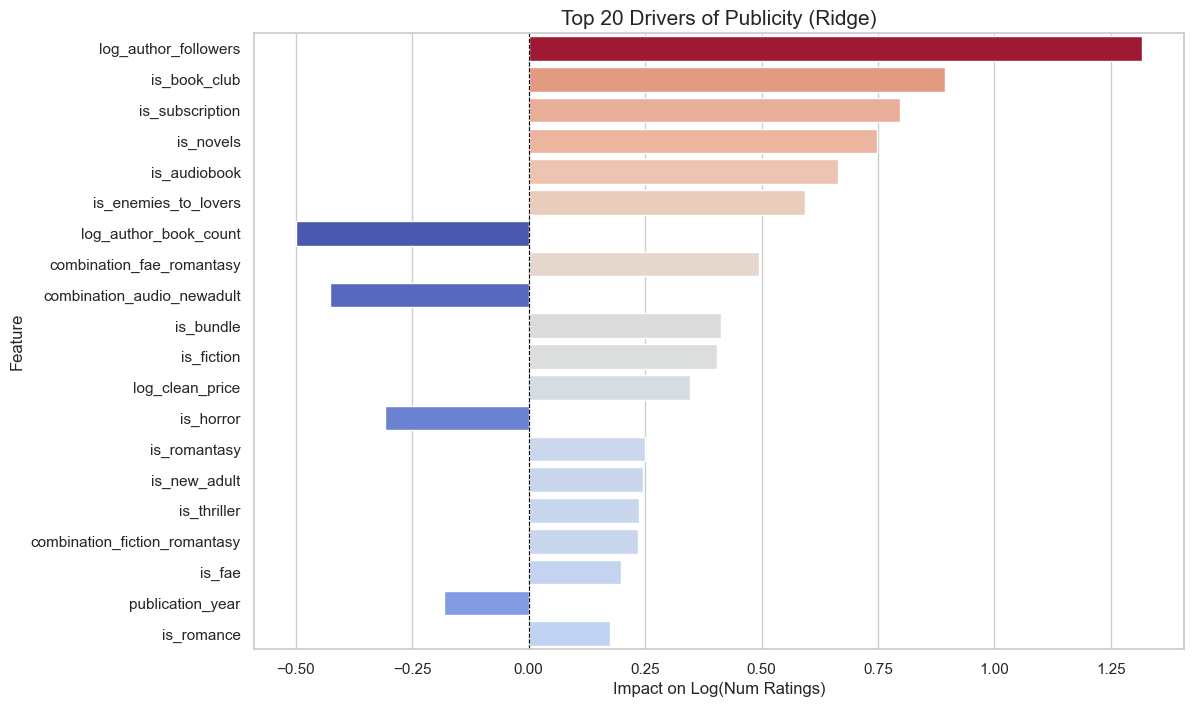

In [23]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': final_model.coef_
})
coef_df['Abs_Coef'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coef', ascending=False).head(20)

print("\nDetailed Feature Weights")
print("-" * 50)
print(f"{'Feature':<35} | {'Coefficient':<12}")
print("-" * 50)

for _, row in top_features.iterrows():
    print(f"{row['Feature']:<35} | {row['Coefficient']:+.4f}")

print("-" * 50)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_features, 
    y='Feature', 
    x='Coefficient', 
    palette='coolwarm', 
    hue='Coefficient',
    legend=False
)

plt.title(f'Top 20 Drivers of Publicity ({best_model_name})', fontsize=15)
plt.xlabel('Impact on Log(Num Ratings)')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.show()

#### Observation:

**1. Author Reputation**
*   **`log_author_followers` (+1.32)** is the strongest predictor. Author's fame is the primary driver of a book's visibility.
*   **Contrast:** However, **`log_author_book_count` (-0.50)** is negative. This suggests a "Quality over Quantity" effect: authors who churn out hundreds of books get less attention per book than authors who release fewer, better written books.

**2. Pricing Strategies**
*   **`is_subscription` (+0.80)** and **`is_audiobook` (+0.66)** are important positive drivers. This confirms that removing barriers (low cost, easy listening) significantly boosts a book's reach.
*   **`is_bundle` (+0.41)** is also positive, showing that selling books in series helps gain readers.
*   **`log_clean_price` (+0.35)** is positive. This validates our finding that higher-priced books (\$12-\$14 range) get more attention than cheaper books.

**3. Specific Genres**
*   Readers prefer specific types of books. Features like **`is_book_club` (+0.89)** and **`is_novels` (+0.75)** are very strong predictors.

**4. Genre Combinations**
*   The model confirms that combining genres works better than keeping them separate. The weight for the **`combination_fae_romantasy` (+0.49)** is significantly higher than **`is_romantasy` (+0.25)** or **`is_fae` (+0.20)** on their own.

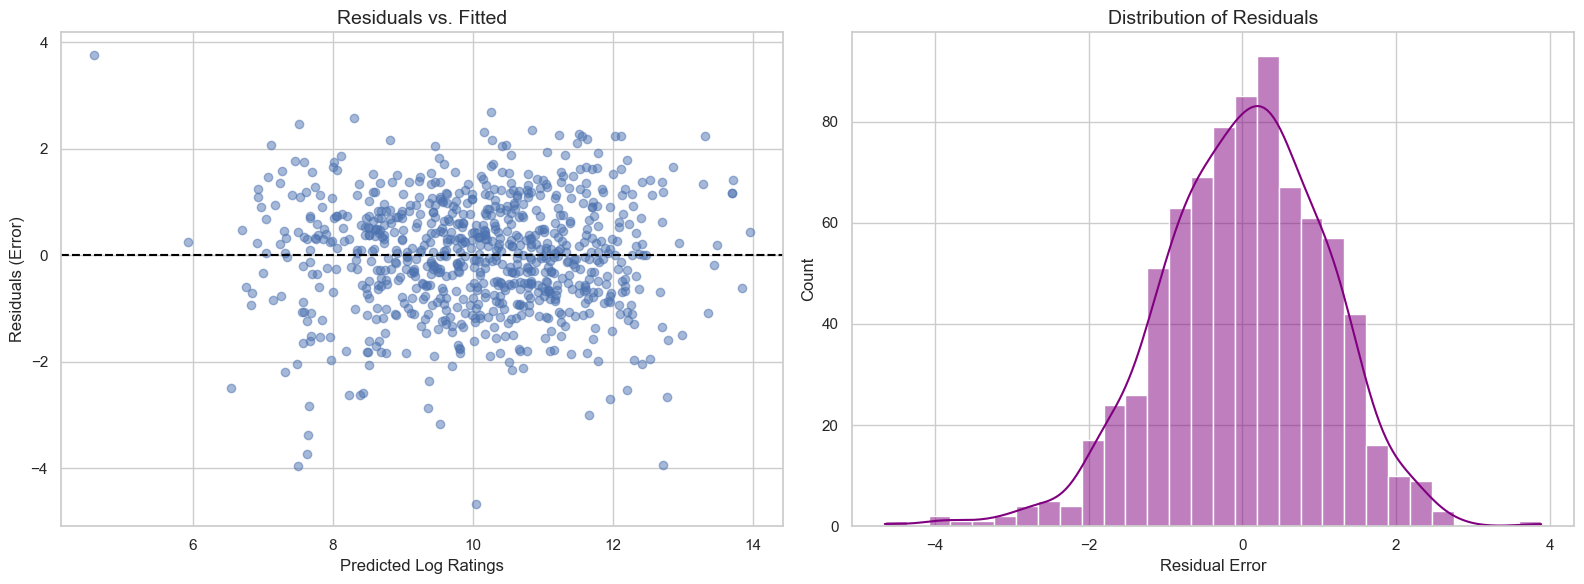

In [24]:
check_X = X_test
check_y = y_test
fitted_values = final_model.predict(check_X)

residuals = check_y - fitted_values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.residplot(
    x=fitted_values, 
    y=residuals, 
    lowess=False, 
    ax=axes[0],
    line_kws={'color': 'red', 'lw': 2},
    scatter_kws={'alpha': 0.5}
)

axes[0].set_title('Residuals vs. Fitted', fontsize=14)
axes[0].set_xlabel('Predicted Log Ratings')
axes[0].set_ylabel('Residuals (Error)')
axes[0].axhline(y=0, color='black', linestyle='--')

sns.histplot(
    residuals, 
    kde=True, 
    ax=axes[1], 
    color='purple', 
    bins=30
)

axes[1].set_title('Distribution of Residuals', fontsize=14)
axes[1].set_xlabel('Residual Error')

plt.tight_layout()
plt.show()

#### Observation:
**1. Residuals vs. Fitted**
*   Residuals centered around the fitted line ($y=0$) and there are no clear patterns. The relationship between our features the Book's Reach is **Linear**.

**2. Distribution of Residuals**
*   **What it means:** The model's errors are random and balanced. It does not systematically guess "too high" or "too low."